In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from tqdm import tqdm
import astropy.units as u
import matplotlib.pyplot as plt
from multiprocessing import Pool
from dynesty import plotting as dyplot

import scipy
from scipy.interpolate import interp1d, CubicSpline
from scipy.stats import norm, linregress
from scipy.spatial.transform import Rotation as R
from sklearn.mixture import GaussianMixture

import astropy.units as u
from astropy.constants import G
G = G.to(u.pc * u.Msun**-1 * (u.km / u.s)**2)

import agama
# working units: 1 Msun, 1 kpc, 1 km/s
agama.setUnits(length=1, velocity=1, mass=1)

from Sergey_dynesty_orbit_2D import *

BAD_VAL = 1e50
SUPER_BAD_VAL = 1e80

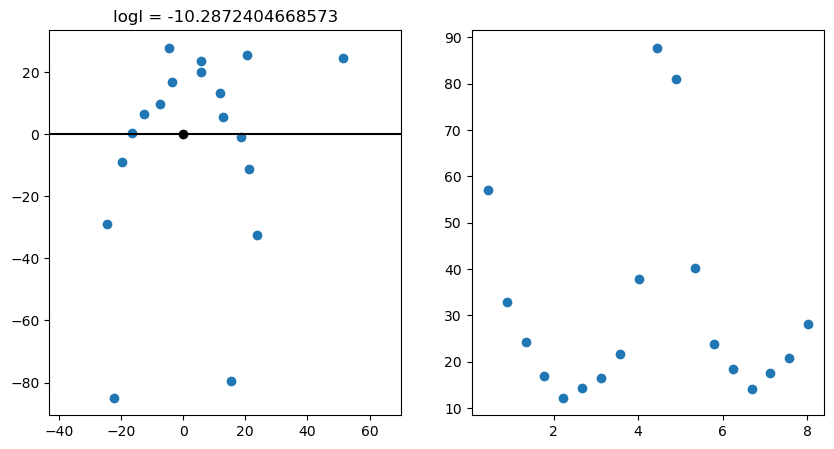

In [26]:
ndim   = 13
sigma  = 1
N_data = 20
dict_data, params_data = get_data_orbit(ndim, 0.8, 'theta', sigma, N_data)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title(f'logl = {log_likelihood_MSE(params_data, dict_data)}')
plt.scatter(dict_data['x'], dict_data['y'])
plt.axis('equal')
plt.scatter(0,0, c='k')
plt.axhline(0, color='k')
plt.subplot(1,2,2)
plt.scatter(dict_data['theta'], dict_data['r'])

In [10]:


xy_model    = model(params_data)
r_model     = np.sqrt(xy_model[0]**2 + xy_model[1]**2)
theta_model = np.unwrap(np.arctan2(xy_model[1], xy_model[0]))

overlap = (np.diff(theta_model) <= 0).sum()
if overlap != 0:
    logl = -SUPER_BAD_VAL * overlap

else: 
    f = interp1d(theta_model, r_model, kind='cubic', bounds_error=False, fill_value=np.nan)
    r_fit = f(dict_data['theta'])

    # Punish for too short
    N_nan = np.sum(np.isnan(r_fit))

    if N_nan > 0:
        logl = -BAD_VAL *  N_nan
    else:
        logl = -0.5*np.sum( (dict_data['r'] - r_fit)**2/dict_data['r_sigma']**2 + np.log(dict_data['r_sigma']**2) )

In [14]:
np.log(dict_data['r_sigma']**2)

array([-18.42068074, -18.42068074, -18.42068074, -18.42068074,
       -18.42068074, -18.42068074, -18.42068074, -18.42068074,
       -18.42068074, -18.42068074, -18.42068074, -18.42068074,
       -18.42068074, -18.42068074, -18.42068074, -18.42068074,
       -18.42068074, -18.42068074])